In [96]:
#@Title Import dependencies 

# Machine leaning
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data analysis
import os
import numpy as np
import matplotlib.pyplot as plt

import os
import urllib.request
import zipfile
import shutil

In [97]:
# Get project files
# !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

# !unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [98]:
# 3
# Rescale pixel values from [0, 255] to [0, 1] / normalizing to binary
train_image_generator = ImageDataGenerator(rescale=1.0/255.0)
validation_image_generator = ImageDataGenerator(rescale=1.0/255.0)
test_image_generator = ImageDataGenerator(rescale=1.0/255.0)

# create a subfolder for the test images
dst_dir = os.path.join(test_dir, 'test_img')
os.makedirs(dst_dir, exist_ok=True)

# move all the test images to the new folder
for file in os.listdir(test_dir):
    if file.lower().endswith('.jpg'):
        shutil.move(os.path.join(test_dir, file), os.path.join(dst_dir, file))

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size = ((IMG_HEIGHT, IMG_WIDTH)),
    batch_size = batch_size,
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size = ((IMG_HEIGHT, IMG_WIDTH)),
    batch_size = batch_size,
    class_mode='binary'
)

test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size = ((IMG_HEIGHT, IMG_WIDTH)),
    batch_size = batch_size,
    class_mode= None,
    shuffle = False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


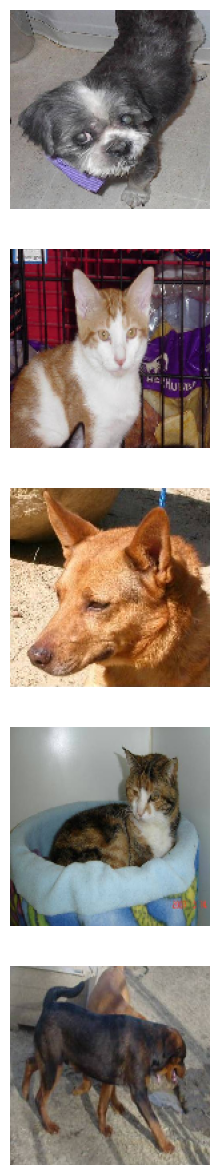

In [99]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [100]:
# 5
# generate more training data from existing training
train_image_generator = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,          # Randomly rotate images (0 to 40 degrees)
    width_shift_range=0.2,      # Randomly shift images horizontally (20%)
    height_shift_range=0.2,     # Randomly shift images vertically (20%)
    shear_range=0.2,            # Random shear transformation
    zoom_range=0.2,             # Random zoom in/out
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill in missing pixels after rotation/shift
)



Found 2000 images belonging to 2 classes.


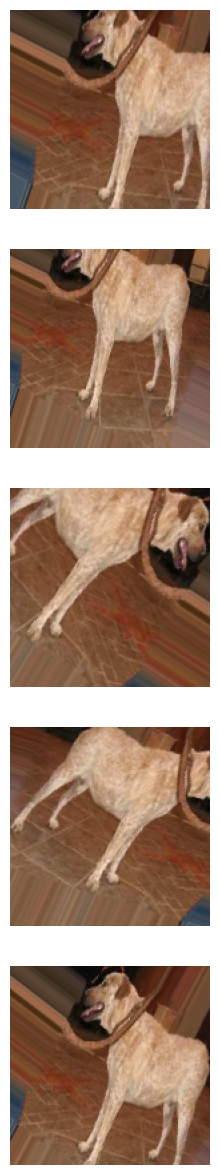

In [101]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [ ]:
# 7
model = tf.keras.Sequential([
    tf.keras.Input(shape=(64,64,3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

AttributeError: 'Sequential' object has no attribute 'complie'